# Use Case 1: Detecting anomalies in traffic logs from government servers.
## Approach
- Load Traffic Logs: Use your existing code with zat to read and parse the conn.log file.
- Feature Selection and Preprocessing: Clean and transform data for machine learning.
- Anomaly Detection Using Isolation Forest: An unsupervised ML model to identify anomalies.
- Visualization: Visualize the anomalies and key patterns.

## Steps Explained:
**Load the Logs:**

- Reads the conn.log.gz file and converts it into a Pandas DataFrame using zat.
**Preprocess Data:**

- Select relevant numeric columns (duration, orig_bytes, resp_bytes, etc.).
- Convert durations to seconds and standardize features for the ML algorithm.
- Fill missing values with 0.
**Anomaly Detection:**

- Use Isolation Forest, a machine learning model that works well for unsupervised anomaly detection. It identifies outliers based on the "isolation" of data points.
**Visualization:**

- Scatter plots to visualize anomalies.
- Bar charts to count the number of anomalies and compare them to normal traffic.
**Detected Anomalies:**

- Display the top detected anomalies with key details like:
  - Timestamp (ts)
  - Source IP (id.orig_h)
  - Destination IP (id.resp_h)
  - orig_bytes and resp_bytes.

DataFrame loaded successfully!


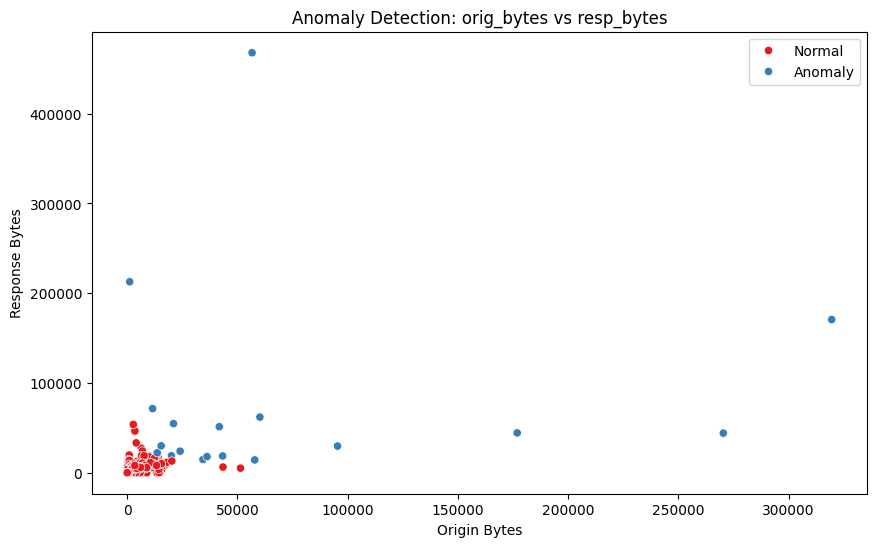

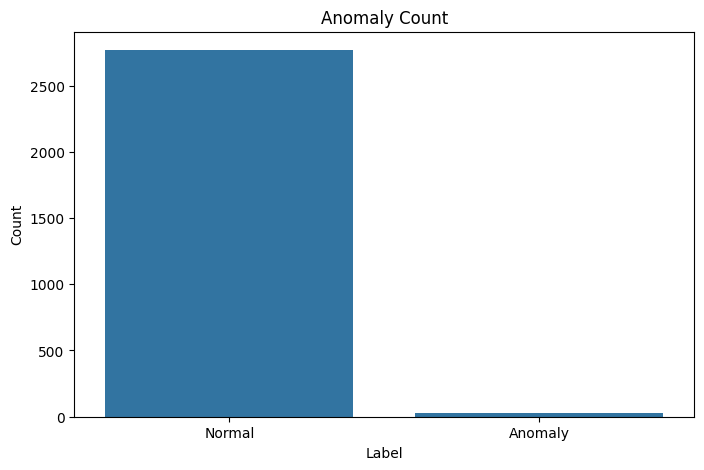

Detected Anomalies:
                               ts        id.orig_h       id.resp_h  \
123 2024-12-16 10:02:31.603799105  192.168.127.114   216.58.196.42   
264 2024-12-16 10:07:21.442821026   192.168.28.229   192.168.28.31   
437 2024-12-16 10:07:17.941451073   192.168.28.229  185.125.188.54   
445 2024-12-16 10:07:17.150640011   192.168.28.229  142.250.199.14   
446 2024-12-16 10:07:17.150346994   192.168.28.229   216.58.200.14   

     orig_bytes  resp_bytes  
123       10597        6657  
264        1169      212727  
437       56678      467836  
445       34401       14776  
446       57891       14265  


In [4]:
import gzip
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zat.log_to_dataframe import LogToDataFrame
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Step 1: Load and Read Zeek Logs
def load_conn_log(file_path):
    """Load Zeek conn.log.gz file."""
    with gzip.open(file_path, 'rb') as gzipped_file:
        with tempfile.NamedTemporaryFile(mode='wb', delete=False) as temp_file:
            temp_file.write(gzipped_file.read())
            uncompressed_path = temp_file.name

    # Use zat to parse the log file
    log_to_df = LogToDataFrame()
    df = log_to_df.create_dataframe(uncompressed_path).reset_index()
    print("DataFrame loaded successfully!")
    return df

# Step 2: Preprocess Data for Machine Learning
def preprocess_data(df):
    """Select and preprocess features for ML."""
    # Drop columns with too many NaN values and non-numeric features
    df = df.drop(columns=['tunnel_parents'], errors='ignore')
    
    # Convert duration to seconds and replace NaT with 0
    df['duration'] = df['duration'].dt.total_seconds().fillna(0)
    
    # Replace missing values in numeric columns with 0
    # df.fillna(0, inplace=True)
    df.dropna(axis=0)

    # Select numeric columns for anomaly detection
    feature_columns = ['duration', 'orig_bytes', 'resp_bytes', 
                       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']
    
    df_numeric = df[feature_columns]
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_numeric)
    
    return scaled_features, df

# Step 3: Apply Isolation Forest for Anomaly Detection
def detect_anomalies(features, contamination=0.01):
    """Run Isolation Forest to detect anomalies."""
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    predictions = iso_forest.fit_predict(features)
    return predictions

# Step 4: Visualize Anomalies
def visualize_anomalies(df, predictions):
    """Visualize the anomalies using scatter plots."""
    df['anomaly'] = predictions
    df['anomaly_label'] = df['anomaly'].map({1: "Normal", -1: "Anomaly"})
    
    # Scatter plot: orig_bytes vs resp_bytes
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='orig_bytes', y='resp_bytes', hue='anomaly_label', data=df, palette='Set1')
    plt.title('Anomaly Detection: orig_bytes vs resp_bytes')
    plt.xlabel('Origin Bytes')
    plt.ylabel('Response Bytes')
    plt.legend()
    plt.show()

    # Bar plot: Number of anomalies detected
    anomaly_counts = df['anomaly_label'].value_counts()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values)
    plt.title("Anomaly Count")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

# Main function
def main():
    file_path = "../zeek/logs/2024-12-16/conn.10:00:00-11:00:00.log.gz"
    
    # Load logs
    df = load_conn_log(file_path)
    
    # Preprocess the data
    features, df_cleaned = preprocess_data(df)
    
    # Detect anomalies
    predictions = detect_anomalies(features, contamination=0.01)  # 1% anomalies
    
    # Visualize anomalies
    visualize_anomalies(df_cleaned, predictions)
    
    # Show the detected anomalies
    anomalies = df_cleaned[df_cleaned['anomaly'] == -1]
    print("Detected Anomalies:")
    print(anomalies[['ts', 'id.orig_h', 'id.resp_h', 'orig_bytes', 'resp_bytes']].head())

if __name__ == "__main__":
    main()
